# Gumbel

@author: Yi, June 11 2021

本文介绍 Gumbel-Max/SoftMax。

参考：https://casmls.github.io/general/2017/02/01/GumbelSoftmax.html


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

- 从 ArgMax 采样：没有随机性，不可导
- 从 SoftMax 采样：有随机性，不可导
- 从 SoftMax + temperate 采样：随着 temperate 降低，有随机性->无随机性，不可导
- 从 Gumbel-Max 采样：有随机性，不可导
- 从 Gumbel-SoftMax 采样：随着 temperate 降低，随机性接近原始分布


In [2]:
def gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_max(logits, temperature):
    y = logits + gumbel(logits.size())
    return y.argmax(dim=-1, keepdims=True)


def gumbel_softmax(logits, temperature):
    y = logits + gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def softmax(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

def hard_gumbel_softmax(logits, temperature):
    # straight-through gumbel softmax
    y = gumbel_softmax(logits, temperature)

    # convert to one-hot
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y)
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard

<AxesSubplot:ylabel='Density'>

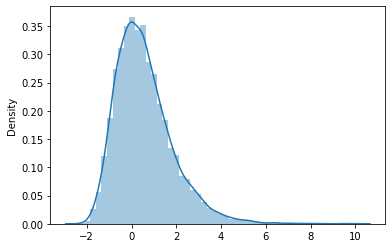

In [5]:
sns.distplot(gumbel(10000).numpy())

In [4]:
probs = torch.tensor([[0.1, 0.2, 0.3, 0.4]])
logits = probs.log()

## SoftMax = Gumbel-Max 

核心：加个随机噪声（uniform）即可模拟指定分布的采样，re-parameterization（跟 Gumbel-SoftMax 无关！）

Gumbel-Max 
- 每次修改概率分布，然后取 argmax
- 最终样本的分布符合原始分布

(array([ 997.,    0.,    0., 2019.,    0.,    0., 3068.,    0.,    0.,
        3916.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

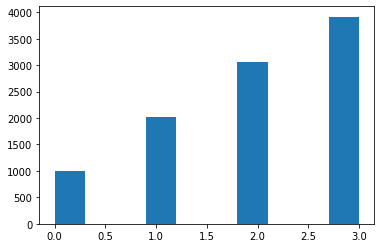

In [20]:
# directly sample from softmax
samples = np.random.choice([0, 1, 2, 3], size=(10000), p=probs.view(-1).numpy())
plt.hist(samples)

(array([1028.,    0.,    0., 1989.,    0.,    0., 2988.,    0.,    0.,
        3995.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

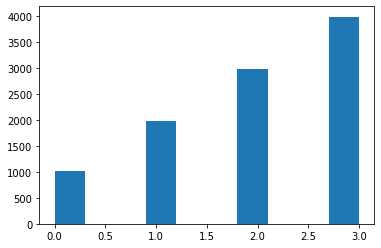

In [34]:
# sample from gumbel(0, 1), add it to logits, and compute the argmax
samples = gumbel_max(logits.expand(10000, -1), 1).view(-1).numpy()
plt.hist(samples)

## Softmax + temperature !=  Gumbel-Softmax + temperature

参考：https://datascience.stackexchange.com/questions/58376/gumbel-softmax-trick-vs-softmax-with-temperature

其中：

- Softmax + temperature
    - 每次采样使用的概率分布一样
    - temperature 小的时候，最大类别的概率会越大，最小类别的概率会越来越小
    - temperature=1 时，等同于原始分布
    - 最终采样出来的分布已经不是原始分布
- Gumbel-Softmax + temperature
    - 每次采样之前修改了概率分布
    - temperature 可以控制每次采样基于的概率分布（更加平坦/更加尖锐），bias-variance trade-off。
    - temprature=0 时（也就是 Gumbel-Max），采样出来的符合原始分布，但是采样时基于的分布是 one-hot

In [121]:
# numpy 不支持 2d-choice
def random_choice_prob_index(a, axis=1):
    r = np.expand_dims(np.random.rand(a.shape[1-axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

random_choice_prob_index(np.array([[0.1, 0.9], [0.9, 0.1]]))

array([0, 1])

In [127]:
torch.set_printoptions(precision=4, sci_mode=False)

temp=0.1, probs=
tensor([[    0.0006,     0.9994,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0077,     0.9923],
        [    0.0000,     0.0000,     0.0000,     1.0000]])
temp=1.0, probs=
tensor([[0.0128, 0.3398, 0.6138, 0.0336],
        [0.0300, 0.2642, 0.5936, 0.1122],
        [0.3044, 0.4510, 0.0864, 0.1581]])
temp=10.0, probs=
tensor([[0.2580, 0.2812, 0.2258, 0.2351],
        [0.2216, 0.2827, 0.2332, 0.2625],
        [0.2234, 0.2508, 0.2901, 0.2357]])


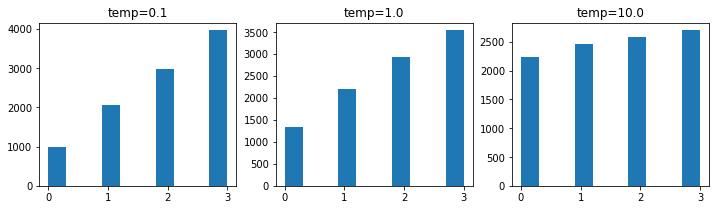

In [128]:
plt.figure(figsize=(12, 3))
for tid, temp in enumerate([0.1, 1.0, 10.0]):
    probs = gumbel_softmax(logits.expand(10000, -1), temp)  # -> 10000 个不同的分布
    print(f"temp={temp}, probs=\n{probs[:3]}")
    # samples = probs.argmax(-1).numpy()
    samples = random_choice_prob_index(probs.numpy())
    plt.subplot(1, 3, tid + 1)
    plt.hist(samples)
    plt.title(f"temp={temp}")

temp=0.1, probs=
tensor([[    0.0000,     0.0009,     0.0533,     0.9458],
        [    0.0000,     0.0009,     0.0533,     0.9458],
        [    0.0000,     0.0009,     0.0533,     0.9458]])
temp=1.0, probs=
tensor([[0.1000, 0.2000, 0.3000, 0.4000],
        [0.1000, 0.2000, 0.3000, 0.4000],
        [0.1000, 0.2000, 0.3000, 0.4000]])
temp=10.0, probs=
tensor([[0.2306, 0.2471, 0.2574, 0.2649],
        [0.2306, 0.2471, 0.2574, 0.2649],
        [0.2306, 0.2471, 0.2574, 0.2649]])


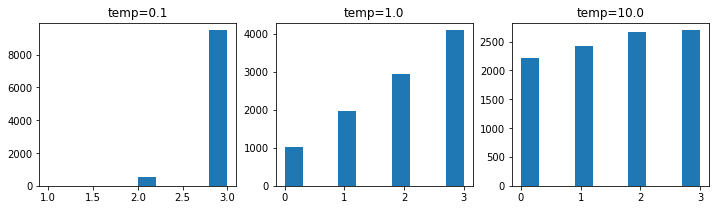

In [129]:
plt.figure(figsize=(12, 3))
for tid, temp in enumerate([0.1, 1.0, 10.0]):
    probs = softmax(logits.expand(10000, -1), temp)
    print(f"temp={temp}, probs=\n{probs[:3]}")
    samples = np.random.choice([0, 1, 2, 3], size=(10000), p=probs[0].numpy())
    plt.subplot(1, 3, tid + 1)
    plt.hist(samples)
    plt.title(f"temp={temp}")

## Straight-Through Gumbel-SoftMax

Property 1 **Rounding**: 

$P(X_k^\tau > X_i^\tau, k \neq i) = \frac{\alpha_k}{\sum \alpha}$

不管 $\tau$ 为多少，某个类别最大的概率和原始分布一致。

为了保持离散特性，可以引出 Straight-Through Gumbel-SoftMax，直接取 max 然后使用 (index - logits).detach() + logits 来代替 logits。

temp=0.1, probs=
tensor([[1.0845e-06, 1.0589e-04, 4.3888e-04, 9.9945e-01],
        [9.9980e-01, 7.7622e-13, 1.2118e-09, 2.0445e-04],
        [5.0858e-20, 6.2245e-09, 1.0000e+00, 1.9041e-13]])
temp=1.0, probs=
tensor([[0.0110, 0.1215, 0.8083, 0.0591],
        [0.0332, 0.3564, 0.5071, 0.1033],
        [0.0085, 0.0537, 0.0365, 0.9014]])
temp=10.0, probs=
tensor([[0.2233, 0.2645, 0.2349, 0.2773],
        [0.2671, 0.2553, 0.2235, 0.2542],
        [0.2516, 0.2289, 0.2709, 0.2486]])


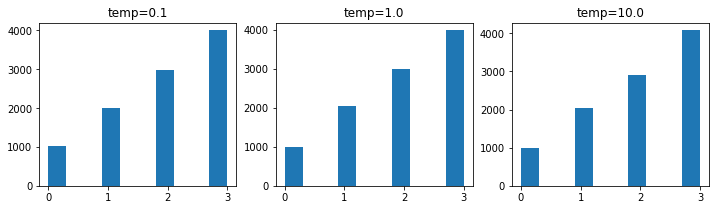

In [5]:
plt.figure(figsize=(12, 3))
for tid, temp in enumerate([0.1, 1.0, 10.0]):
    probs = gumbel_softmax(logits.expand(10000, -1), temp)  # -> 10000 个不同的分布
    print(f"temp={temp}, probs=\n{probs[:3]}")
    samples = probs.argmax(-1).numpy()
    # samples = random_choice_prob_index(probs.numpy())
    plt.subplot(1, 3, tid + 1)
    plt.hist(samples)
    plt.title(f"temp={temp}")

In [216]:
# 设置一个小的 temperature 可以模拟采样（one-hot），且很接近真实分布
print(gumbel_softmax(logits, 0.05))

tensor([[    0.0000,     0.0000,     0.0000,     1.0000]],
       grad_fn=<SoftmaxBackward>)
